<a href="https://colab.research.google.com/github/MRdvan/Pytorch-Training/blob/master/Pytorch-fundamentals-to-deploy/02_PyTorch_Classification_with_Neural_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

* binary classsification -> yes or no
* multi class classficaiton -> one of the options
* multi label classificaiton -> more then one class 

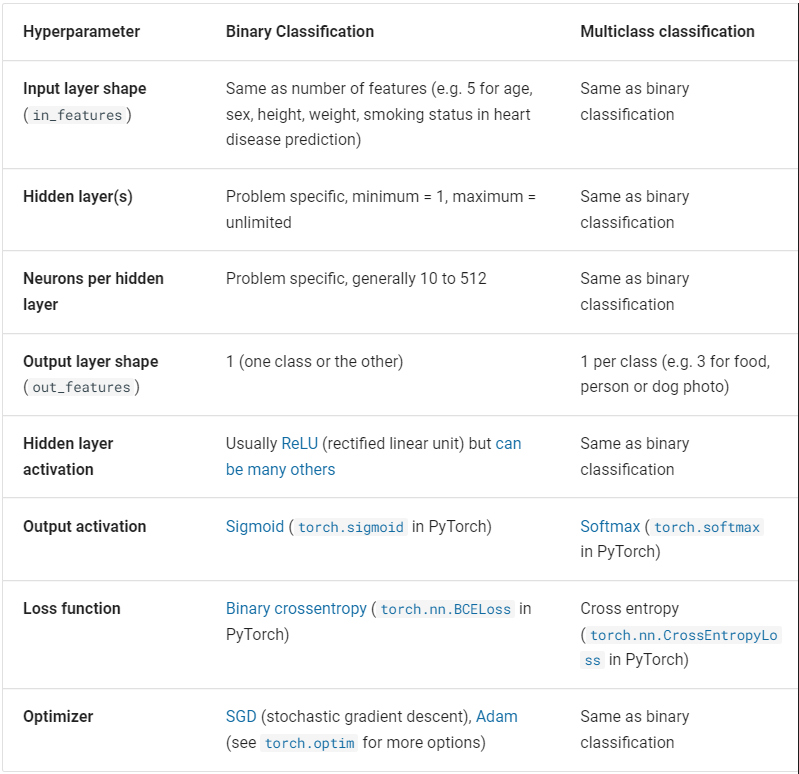

## Creating classificaiton data with circles

In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,noise = 0.03,random_state = 42)

In [2]:
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]), array([1, 1, 1, 1, 0]))

In [3]:
import pandas as pd

circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
#check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

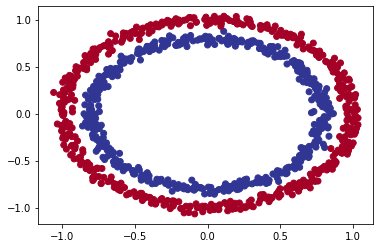

In [5]:
import matplotlib.pyplot as plt
#red dots -> y=0
#blue dots -> y=1
plt.scatter(x=circles["X1"],y = circles["X2"],c=y,cmap=plt.cm.RdYlBu)

In [6]:
# İmportant to always check the shape of your data
X.shape, y.shape
# x has two features and y is scaler

((1000, 2), (1000,))

In [7]:
# Turn data into tensors
# Otherwise this causes issues with computations later on also we cant access gpu when using numpy
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [8]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

## Building a Model

In [9]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [10]:
class CircleModel(nn.Module):
  def __init__(self,in_features,out_features,num_class):
    super().__init__()
    self.layer1 = nn.Linear(in_features,out_features)
    self.layer2 = nn.Linear(out_features,10)
    self.layer3 = nn.Linear(10,num_class)
    self.relu = nn.ReLU()
  
  def forward(self,x:torch.Tensor):
    out1 = self.relu(self.layer1(x))
    out2 = self.relu(self.layer2(out1))
    out3 = self.layer3(out2)
    return out3

# Replicate CircleModel with nn.Sequential
# nn.Sequential -> is a container that holds layers and nn.functions it calls them in order (first output -> second input like)
"""CircleModel_seqfrom = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)"""
# because it only flows sequentialy when we need to do non sequential things we need to create our own custom module

hidden_size = 10
model = CircleModel(2,hidden_size,1).to(device)

In [11]:
model

CircleModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [12]:
# Make predictions with the model -> to see prediction shape type is matching with labels
untrained_preds = model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.1068],
        [0.1086],
        [0.1103],
        [0.1148],
        [0.0544],
        [0.0449],
        [0.0540],
        [0.0453],
        [0.1101],
        [0.1059]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])



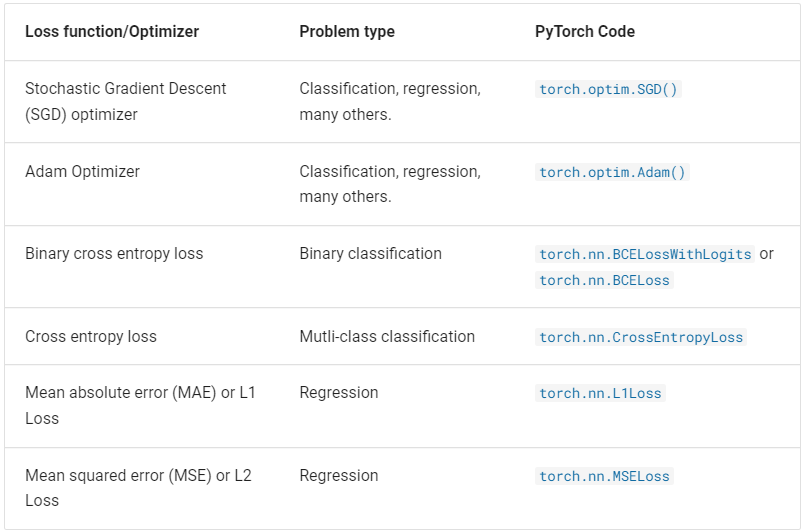

In [13]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.1)

In [14]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## Train Model

In [15]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[0.1068],
        [0.1086],
        [0.1103],
        [0.1148],
        [0.0544]], grad_fn=<SliceBackward0>)

In [16]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5267],
        [0.5271],
        [0.5275],
        [0.5287],
        [0.5136]], grad_fn=<SigmoidBackward0>)

In [17]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))
# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

In [18]:
y_test[:5]
accuracy_fn(y_preds.squeeze(),y_test[:5])

60.0

In [19]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69413, Accuracy: 50.00% | Test Loss: 0.69339, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69033, Accuracy: 66.25% | Test Loss: 0.69206, Test Accuracy: 63.00%
Epoch: 200 | Loss: 0.68830, Accuracy: 52.25% | Test Loss: 0.69207, Test Accuracy: 46.50%
Epoch: 300 | Loss: 0.68592, Accuracy: 53.50% | Test Loss: 0.69143, Test Accuracy: 47.50%
Epoch: 400 | Loss: 0.68291, Accuracy: 61.00% | Test Loss: 0.69006, Test Accuracy: 58.50%
Epoch: 500 | Loss: 0.67910, Accuracy: 61.62% | Test Loss: 0.68815, Test Accuracy: 58.00%
Epoch: 600 | Loss: 0.67432, Accuracy: 60.25% | Test Loss: 0.68542, Test Accuracy: 54.00%
Epoch: 700 | Loss: 0.66848, Accuracy: 59.88% | Test Loss: 0.68155, Test Accuracy: 55.00%
Epoch: 800 | Loss: 0.66107, Accuracy: 59.88% | Test Loss: 0.67651, Test Accuracy: 56.50%
Epoch: 900 | Loss: 0.65120, Accuracy: 60.50% | Test Loss: 0.66921, Test Accuracy: 55.00%


## Model evaluate & Prediction

In [20]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [21]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



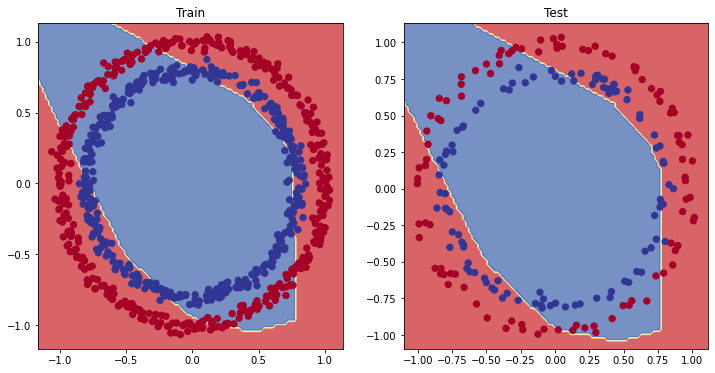

In [22]:
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

* Model can't fit the data because we are not using any non-linearity to solve this problem

## Improving Model
-if model is underfit to your problem;

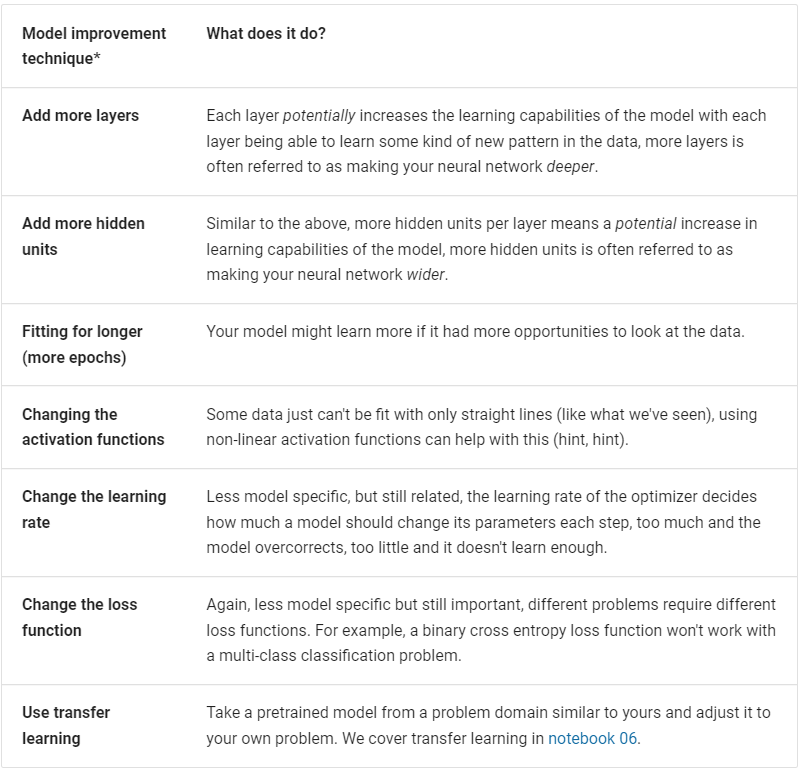

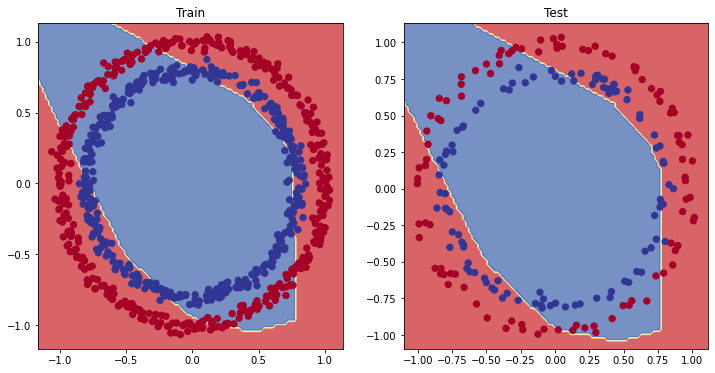

In [23]:
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

## Replicating non-linear activation functions

In [24]:
A = torch.arange(-10,10,1,dtype = torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

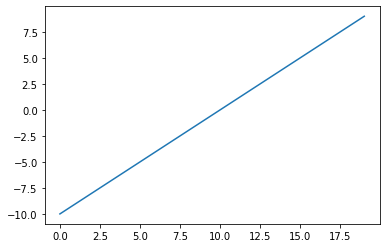

In [28]:
plt.plot(A);

In [30]:
# Create relu function

def relu(x):
  return torch.maximum(torch.tensor(0),x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

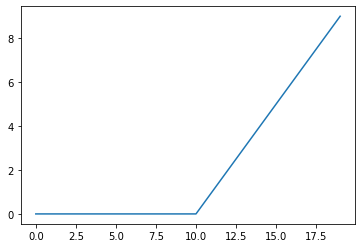

In [31]:
plt.plot(relu(A))

In [32]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

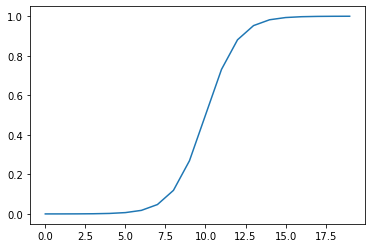

In [33]:
plt.plot(sigmoid(A))

## Build multi-class model

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


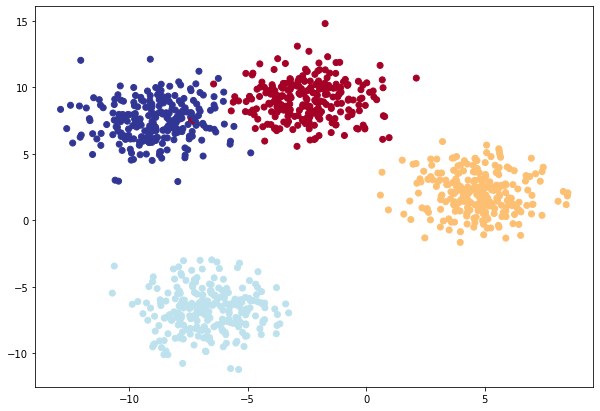

In [34]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [35]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


In [36]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_m = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_m

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [37]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss() # this loss function used for multi class classifications
optimizer = torch.optim.SGD(model_m.parameters(), 
                            lr=0.1)

In [38]:
# Perform a single forward pass on the data
model_m(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [40]:
# How many elements in a single prediction sample?
model_m(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [41]:
# Make prediction logits with model
y_logits = model_m(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


In [42]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [43]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


* To summarize the above, a model's raw output is referred to as **logits**.

* For a multi-class classification problem, to turn the logits into prediction probabilities, you use the **softmax activation** function (torch.softmax).

* The index of the value with the highest **prediction probability** is the class number the model thinks

In [49]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_m.train()

    # 1. Forward pass
    y_logits = model_m(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) #crossentropyloss takes logits
    acc = accuracy_fn(y_true=y_blob_train, #to check accuracy we need predicted class numbers
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_m.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_m(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.03185, Acc: 99.12% | Test Loss: 0.02293, Test Acc: 99.50%
Epoch: 10 | Loss: 0.03093, Acc: 99.12% | Test Loss: 0.02186, Test Acc: 99.50%
Epoch: 20 | Loss: 0.03017, Acc: 99.12% | Test Loss: 0.02097, Test Acc: 99.50%
Epoch: 30 | Loss: 0.02955, Acc: 99.12% | Test Loss: 0.02022, Test Acc: 99.50%
Epoch: 40 | Loss: 0.02902, Acc: 99.12% | Test Loss: 0.01958, Test Acc: 99.50%
Epoch: 50 | Loss: 0.02857, Acc: 99.12% | Test Loss: 0.01902, Test Acc: 99.50%
Epoch: 60 | Loss: 0.02819, Acc: 99.12% | Test Loss: 0.01852, Test Acc: 99.50%
Epoch: 70 | Loss: 0.02785, Acc: 99.12% | Test Loss: 0.01809, Test Acc: 99.50%
Epoch: 80 | Loss: 0.02756, Acc: 99.12% | Test Loss: 0.01770, Test Acc: 99.50%
Epoch: 90 | Loss: 0.02730, Acc: 99.12% | Test Loss: 0.01735, Test Acc: 99.50%


In [45]:
# Make predictions
model_m.eval()
with torch.inference_mode():
    y_logits = model_m(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

**Note:** *It's possible to skip the torch.softmax() function and go straight from predicted logits -> predicted labels by calling torch.argmax() directly on the logits.*

*For example, y_preds = torch.argmax(y_logits, dim=1), this saves a computation step (no torch.softmax()) but results in no prediction probabilities being available to use.*

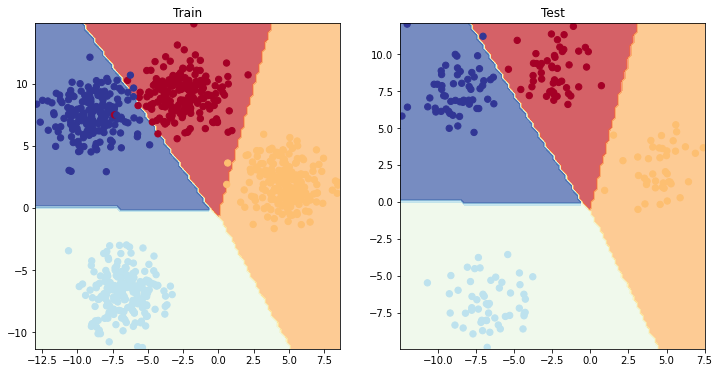

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_m, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_m, X_blob_test, y_blob_test)

## other metrics

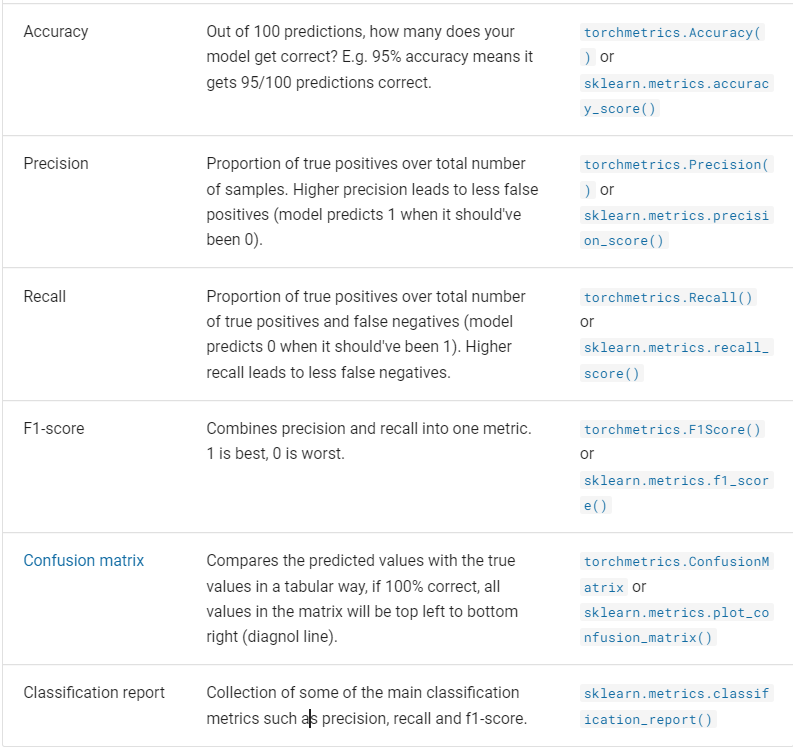